# SpaceTime Matrix demo

### Data used for this notebook
- Space-time Matrix in `Zarr` format: [download](https://figshare.com/ndownloader/files/41957250)
- Crop parcel polygons in `gpkg` format: [download](https://figshare.com/ndownloader/files/41012630)

Refer to the [tutorial](https://github.com/MotionbyLearning/sarxarray/blob/main/examples/demo_sarxarray.ipynb) of `sarxarray` to see how to generate a STM from a SLC stack.

### Setup environment
For the python environment setup, we assume you already started an independent Python environment with Python version later than 3.10.

To execute this notebook, first clone the `stm` repostory to your local and install it with `demo` extra options

```sh
git clone git@github.com:MotionbyLearning/stm.git
cd stm
pip install .[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running `jupyterlab` command in your command line:
```bash
jupyter-lab
```

A new tab will be opened in your default browser to execute this notebook.

In [1]:
import numpy as np
from pathlib import Path
import stmtools

### Loading SpaceTime Matrix from CSV file

In [2]:
# Reading example data
stm_demo = stmtools.from_csv('./data/example.csv')
stm_demo

<xarray.Dataset>
Dimensions:                (space: 2500, time: 11)
Coordinates:
  * space                  (space) int64 0 1 2 3 4 ... 2495 2496 2497 2498 2499
  * time                   (time) int64 0 1 2 3 4 5 6 7 8 9 10
    lat                    (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    lon                    (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
Data variables: (12/13)
    pnt_id                 (space) object dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_flags              (space) int64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_line               (space) int64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_pixel              (space) int64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_height             (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_demheight          (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    ...                     ...
    pnt_enscoh             (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_ampconsist         (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    pnt_linear             (space) float64 dask.array<chunksize=(2500,), meta=np.ndarray>
    deformation            (space, time) float64 dask.array<chunksize=(2500, 11), meta=np.ndarray>
    amplitude              (space, time) float64 dask.array<chunksize=(2500, 11), meta=np.ndarray>
    h2ph                   (space, time) float64 dask.array<chunksize=(2500, 11), meta=np.ndarray>

### Loading SpaceTime Matrix from Zarr

In [3]:
import xarray as xr
path_stm = Path('./stm.zarr')
stm_demo = xr.open_zarr(path_stm)
stm_demo = stm_demo.chunk({"points": 10000, "time":-1})
stm_demo

<xarray.Dataset>
Dimensions:    (points: 318225, time: 10)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>

### STM enrichment from Polygon file

In [4]:
# Path to the BRP polygon of NL
path_polygon = Path('../../data/brp/brpgewaspercelen_concept_2022_wgs84.gpkg')

In [5]:
import geopandas as gpd
# Read one row and check columns
polygons_one_row = gpd.read_file(path_polygon, rows=1)
polygons_one_row

,category,gewas,gewascode,jaar,status,geometry
0,Bouwland,"Tarwe, winter-",233,2022,Concept,"POLYGON ((5.55271 52.50400, 5.55311 52.50411, ..."


In [6]:
import stmtools

# Data enrichment
fields_to_query = ['gewas', 'category']

# When AoI is small and less number of chunks: directly feed in the polygon file. Multi-process can be blocked by file IO
stm_demo = stm_demo.stm.enrich_from_polygon(path_polygon, fields_to_query)

# # When AoI is big and large number of chunks: First load in the polygons
# xmin, ymin, xmax, ymax = [
#         stm_demo['lon'].data.min().compute(),
#         stm_demo['lat'].data.min().compute(),
#         stm_demo['lon'].data.max().compute(),
#         stm_demo['lat'].data.max().compute(),
#     ]
# polygons = gpd.read_file(path_polygon, bbox=(xmin, ymin, xmax, ymax))
# stm_demo = stm_demo.stm.enrich_from_polygon(polygons, fields_to_query)

In [7]:
stm_demo

<xarray.Dataset>
Dimensions:    (time: 10, points: 318225)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    azimuth    (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(10000,), meta=np.ndarray>
    category   (points) object dask.array<chunksize=(10000,), meta=np.ndarray>

### Subset by Polygons

In [8]:
stm_demo_subset = stm_demo.stm.subset(method='polygon', polygon=path_polygon)
stm_demo_subset

<xarray.Dataset>
Dimensions:    (time: 10, points: 24106)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    azimuth    (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(10000, 10), meta=np.ndarray>
    gewas      (points) object dask.array<chunksize=(10000,), meta=np.ndarray>
    category   (points) object dask.array<chunksize=(10000,), meta=np.ndarray>

### Visualize the points

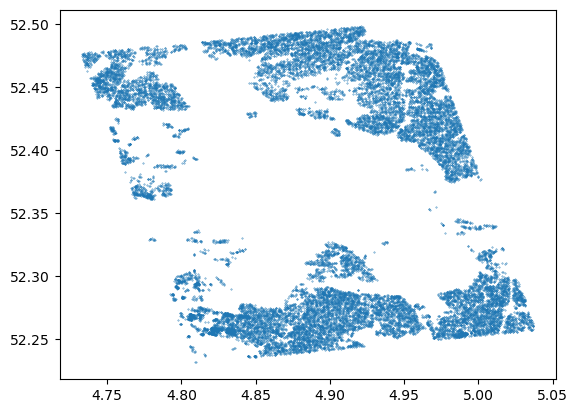

In [9]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.scatter(stm_demo_subset.lon.data, stm_demo_subset.lat.data, s=0.1)